In [451]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from time import sleep
from threading import Thread, Event
import nxsdk_modules.input_generator.input_generator as nxm
from nxsdk.utils.plotutils import plotRaster
import array as arr
from spikes import encoder
from spikes.utility import ReadCSV
import random as rd
from scipy.stats import kde
import timeit
import scipy as scp

def thread_functionpst(newper,srcpst,window,delT):
    for i in range(int(window/delT)):
        sleep(newper)
        srcpst.sendSpikes(spikeInputPortNodeIds=[1], numSpikes=[1])
    
def thread_functionmem(memper,srcmem,window,memsteps):
    for i in range(int(window/memsteps)):
        #print("entered tempmem")
        sleep(memper)
        srcmem.sendSpikes(spikeInputPortNodeIds=[2], numSpikes=[1])

        

In [452]:
%store -r rnum

### Network Creation and Connection

Two signal generators, one is interactive (C(t)) while one is basic (CT). There are two output neurons, each neuron deciding the direction to go in, i.e. either up or down. Through each time window, the output spikes will be read from both the neurons and a decision will be made accordinigly. The decision will be executed by motor neurons (which is the python based calculation in this experiment). After the locomotion, the resulting signal will be sent to the interactive signal generator by the "motor neurons" and the process will be repeated.

In [453]:
net = nx.NxNet()

cxp = nx.CompartmentPrototype( 
                              vThMant= 100,                  #a low threshold for passing the same frequency in o/p
                              compartmentVoltageDecay = 1,
                              compartmentCurrentDecay = 2**12,
                              functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

outup = net.createCompartmentGroup(size=1,prototype=cxp)            #output neuron for up gradient decision
outdown = net.createCompartmentGroup(size=1,prototype=cxp)          #output neuron for down gradient decision
#temppst = net.createCompartmentGroup(size=1,prototype=cxp)          #neuron to observe the present conc profile
#tempset = net.createCompartmentGroup(size=1,prototype=cxp)          #neuron to observe the set conc profile

gradup = net.createCompartmentGroup(size=1,prototype=cxp)           #present conc - up conc
graddown = net.createCompartmentGroup(size=1,prototype=cxp)         #present conc - down conc
#tempmem = net.createCompartmentGroup(size=1,prototype=cxp)

srcset = net.createSpikeGenProcess(1)                                #setpoint concentration source


conprot = nx.ConnectionPrototype(weight=128)
conprot2 = nx.ConnectionPrototype(weight=-128)

conn1 = srcset.connect(outup, prototype = conprot)                   
conn2 = srcset.connect(outdown, prototype = conprot2)
#connect1 = srcset.connect(tempset, prototype = conprot)

               #total number of time steps for simulation
NUM_PLOTS_PER_RECEIVER = 1 
window = 4000
conclen = 101*101
rows = 101
columns = 101
numsteps = window*(11)
#numsteps = window*(rows)
udlr = ['0100','0101','0001','1001','1000','1010','0010','0110']

## Generating Concentration Space

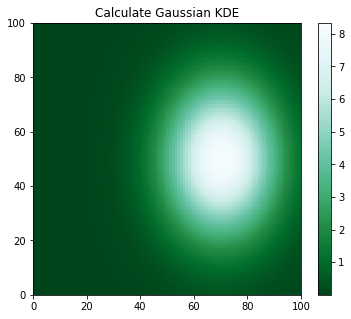

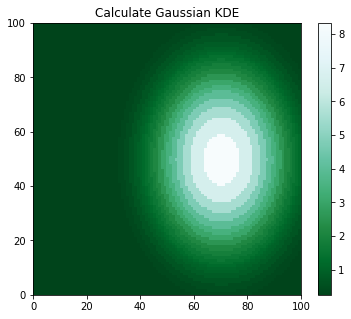

In [454]:


val = [4, 2.7, 2, 1.5, 1.17, 1, 0.91, 0.82, 0.72, 0.62, 0.53, 0.46, 0.39, 0.33, 0.29, 0.25, 0.21, 0.18, 0.15, 0.12 ];
xmin = 0;
xmax = 100;
ymax = 0;
ymin = 100;
nbins = 101;
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
sigmax = 15;
sigmay = 20;
mux = 70
muy = 50

val3 = np.asarray(val)
conc = np.exp(- ((np.power(xi - mux, 2.)/(2 * np.power(sigmax, 2.))) + (np.power(yi - muy,2.)/(2 * np.power(sigmay, 2.)))))
conc = 1/val3.min()*conc

val2 = []
for i in range(len(val)):
    val2.append(1/val[i]) 

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

axes.set_title('Calculate Gaussian KDE')
im = axes.pcolormesh(xi,yi, conc, cmap=plt.cm.BuGn_r)
fig.colorbar(im, ax = axes)
plt.show()

val2 = np.asarray(val2)
for i in range(len(conc)):
    for j in range(len(conc)):
        M = abs(conc[i][j] - val2);
        I = np.argmin(M);
        conc[i][j] = val2[I];

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

axes.set_title('Calculate Gaussian KDE')
im = axes.pcolormesh(xi,yi, conc, cmap=plt.cm.BuGn_r)
fig.colorbar(im, ax = axes)
plt.show()
#print()


In [455]:
print(conc[35][50])

0.5


### Adding Setpoint Concentration

Here we add the basic spikes to the basic signal generator. It will spike at a constant rate and that rate is the encoding of our setpoint concentration.

In [456]:
#rd.seed(23)
spikelist = []

setconcrow = 60
setconccol = 30
settime = 1/conc[setconcrow][setconccol]                                #the setpoint spike train time period in seconds
setsteps = int(settime*100)                 #number of approximate time steps between each spike

#udlr = ['0100','0101','0001','1001','1000','1010','0010','0110']

#rank = 0
initconcrow = 71
initconccol = 23
initvec = 1
indexrow = initconcrow
indexcol = initconccol
initialconc = 1/conc[indexrow][indexcol]
movvec = udlr[initvec]


for i in range(int(numsteps/setsteps)):
    spikelist.append(i*setsteps+1)
    

emp = []
emp.append(spikelist)
srcset.addSpikes([0], emp)

### Adding interactive spike generator

This will provide input from the motor neurons by constantly getting feedback of the motion

In [457]:
srcpst = net.createInteractiveSpikeGenProcess(numPorts=1)

conn3 = srcpst.connect(outup, prototype = conprot2)
conn4 = srcpst.connect(outdown, prototype = conprot)
#connect2 = srcpst.connect(temppst, prototype = conprot)
conn5 = srcpst.connect(gradup, prototype = conprot)
conn6 = srcpst.connect(graddown, prototype = conprot2)

srcmem = net.createInteractiveSpikeGenProcess(numPorts=1)


conn7 = srcmem.connect(gradup, prototype = conprot2)                   
conn8 = srcmem.connect(graddown, prototype = conprot)
#connect3 = srcmem.connect(tempmem, prototype = conprot)


### Spike reception and callable objects

This will recieve spikes midway execution and give the feedback to the interactive spike generator

In [458]:
spkup = nx.SpikeReceiver(net)
outup.connect(spkup)

spkdown = nx.SpikeReceiver(net)
outdown.connect(spkdown)

spkgradup = nx.SpikeReceiver(net)
gradup.connect(spkgradup)

spkgraddown = nx.SpikeReceiver(net)
graddown.connect(spkgraddown)


In [459]:
class Callable:
    def __init__(self, index):
        # data will hold the spike activity for the 3 compartments associated with a spikereceiver
        # Each spikereceiver will have its own Callable instance as the callback. This is denoted by index
        self.data = [[] for i in range(NUM_PLOTS_PER_RECEIVER)]
        self.index = index

    def __call__(self, *args, **kwargs):
        # At every invocation of this method, new data since the last invocation will be passed along.
        # args[0] essentially is a list[list]. Length of the parent list is the number of compartments 
        # connecting to this spike receiver while each sublist is the timeseries data assciated with that
        # compartment accrued since the last invocation. len(args) is 1.
        for compartmentId, tsData in enumerate(args[0]):
            self.data[compartmentId].extend(tsData)
        
callableup = Callable(1)
callabledown = Callable(2)
callablegradup = Callable(3)
callablegraddown = Callable(4)



spkup.callback(callableup)
spkdown.callback(callabledown)
spkgradup.callback(callablegradup)
spkgraddown.callback(callablegraddown)

### Network running and plotting



In [460]:
probeup = outup.probe([nx.ProbeParameter.SPIKE])
probedown = outdown.probe([nx.ProbeParameter.SPIKE])
#probeset = tempset.probe([nx.ProbeParameter.SPIKE])
#probepst = temppst.probe([nx.ProbeParameter.SPIKE])
probegradup = gradup.probe([nx.ProbeParameter.SPIKE])
probegraddown = graddown.probe([nx.ProbeParameter.SPIKE])
#probemem = tempmem.probe([nx.ProbeParameter.SPIKE])

sumtime = 0

net.runAsync(numSteps=numsteps)
        
start = timeit.default_timer()

x = []
y = []
x.append(indexrow)
y.append(columns - 1 - indexcol)

memper = 1/conc[indexrow][indexcol]
#the concentration space is {0.2, 0.4, 0.6}; in this case setpoint conc is 0.4, initial 0.2 

for j in range(int(numsteps/window)):
#for j in range(rows + columns):
    
    
    newper = 1/conc[indexrow][indexcol]
    delT = newper*100
                                   #the setpoint spike train time period in seconds
   
    memsteps = int(memper*100)

    stop = timeit.default_timer()
    sumtime = sumtime + stop-start
    
    
    x1 = Thread(target = thread_functionpst, args=(newper,srcpst,window,delT,))
    x1.start()

    
    x2 = Thread(target = thread_functionmem, args=(memper,srcmem,window,memsteps,))
    x2.start()
    

#     for i in range(int(window/delT)):
#         sleep(newper)
#         srcpst.sendSpikes(spikeInputPortNodeIds=[1], numSpikes=[1])
        
#     for i in range(int(window/rightsteps)):
#         sleep(newperright)
#         ptright.sendSpikes(spikeInputPortNodeIds=[3], numSpikes=[1])
        
#     for i in range(int(window/leftsteps)):
#         sleep(newperleft)
#         ptleft.sendSpikes(spikeInputPortNodeIds=[2], numSpikes=[1]) 
    
    x1.join()
    x2.join()

    start = timeit.default_timer()
    
    arr0 = np.where(callabledown.data[0])[0]
    arr1 = np.where(callableup.data[0])[0]
    arr2 = np.where(callablegradup.data[0])[0]
    arr3 = np.where(callablegraddown.data[0])[0]
    arr0_rev = arr0[::-1]
    arr1_rev = arr1[::-1]
    arr2_rev = arr2[::-1]
    arr3_rev = arr3[::-1]

        
#if down neuron has spiked in this window then down = 1 else down = 0        
    
    if len(arr0) > 1:
        if arr0_rev[1] > (j)*window:
            down = 1
        else:
            down = 0
    
    else:
        down = 0
    

#if up neuron has spiked in this window then up = 1 else up = 0    
    
    if len(arr1) > 1:
        if arr1_rev[1] > (j)*window:
            up = 1
        else: 
            up = 0
    
    else:
        up = 0
        
    
    #print(len(arr1_rev))
#if gradleft neuron has spiked in this window then gl = 1 else gl = 0
        
    if (len(arr2) > 1) and (j > 0):
        if arr2_rev[1] > (j)*window:
            gu = 1
        else:
            gu = 0
    
    else:
        gu = 0


#if gradright neuron has spiked in this window then gr = 1 else gr = 0        
    
    if (len(arr3) > 1) and (j > 0):
        if arr3_rev[1] > (j)*window:
            gd = 1
        else: 
            gd = 0
    
    else:
        gd = 0
        
    
    u = int(movvec[0])
    d = int(movvec[1])
    l = int(movvec[2])
    r = int(movvec[3])
        
    if j!=0 and ((up!=0) or (down!=0)) and (gu == 0) and (gd == 0):
        #randnum = rd.uniform(0,3)
        randnum = rnum[rank]
        rank = rank+1
        if randnum >= 0 and randnum < 1:
            if movvec == udlr[7]:
                movvec = udlr[0]
            else:
                ind = udlr.index(movvec)
                movvec = udlr[ind + 1]
        else:
            if randnum >= 2 and randnum < 3:
                if movvec == udlr[0]:
                    movvec = udlr[7]
                else:
                    ind = udlr.index(movvec)
                    movvec = udlr[ind - 1]
        #print("randnum is", randnum)
    else: 
        if j!=0 and (up == 1) and (down == 0) and (gu == 0) and (gd == 1):
            if movvec == udlr[7]:
                movvec = udlr[0]
            else:
                ind = udlr.index(movvec)
                movvec = udlr[ind + 1]
        
        else:
            if j!=0 and (up == 0) and (down == 1) and (gu == 1) and (gd == 0):
                if movvec == udlr[0]:
                    movvec = udlr[7]
                else:
                    ind = udlr.index(movvec)
                    movvec = udlr[ind - 1]
            
            else:
                if j!=0 and (up == 0) and (down == 0):
                    #randnum = rd.uniform(0,3)
                    randnum = rnum[rank]
                    rank = rank+1
                    if randnum >= 0 and randnum < 1:
                        if movvec == udlr[7]:
                            movvec = udlr[0]
                        else:
                            ind = udlr.index(movvec)
                            movvec = udlr[ind + 1]
                    else:
                        if randnum >= 2 and randnum < 3:
                            if movvec == udlr[0]:
                                movvec = udlr[7]
                            else:
                                ind = udlr.index(movvec)
                                movvec = udlr[ind - 1]
           
                    
    print(j,indexrow, indexcol, conc[indexrow][indexcol], up, down, gu, gd, movvec)
   
        #udlr = ['0100','0101','0001','1001','1000','1010','0010','0110']
    if (movvec == '0100'):
        indexrow = indexrow + 1
    else:
        if (movvec == '0101'):
            indexrow = indexrow + 1
            indexcol = indexcol + 1
        else:
            if (movvec == '0001'):
                indexcol = indexcol + 1
            else:
                if (movvec == '1001'):
                    indexrow = indexrow - 1
                    indexcol = indexcol + 1
                else:
                    if (movvec == '1000'):
                        indexrow = indexrow - 1
                    else:
                        if (movvec == '1010'):
                            indexrow = indexrow - 1
                            indexcol = indexcol - 1
                        else:
                            if (movvec == '0010'):
                                indexcol = indexcol - 1
                            else:
                                if (movvec == '0110'):
                                    indexcol = indexcol - 1
                                    indexrow = indexrow + 1
    
    

    memper = newper        
    x.append(indexrow)
    y.append(columns - 1 - indexcol)
            


net.disconnect()

stop = timeit.default_timer()
sumtime = sumtime + stop-start

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:39845
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Compiling Embedded snips....Done 0.68s
INFO:DRV:      Encoding axons/synapses.....Done 2.92ms
INFO:HST:  Args chip=0 cpu=0 /homes/apoorvki/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1612782198.6445305/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Args chip=0 cpu=1 /homes/apoorvki/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1612782198.6445305/launcher_chip0_lmt1.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.22s
INFO:DRV:      Encoding probes.............Done 0.85ms
INFO:DRV:      Transferring probes.........Done 5.70ms
INFO:DRV:      Configuring registers.......Done 4.18ms
INFO:DRV:      Transferring spikes.........Done 0.07s
0 71 23 3.4482758620689657 1 0 0 0 01

In [461]:

# plt.figure(1,figsize=(17,18))


# ax0 = plt.subplot(8,1,1)
# sh = probeup[0].plot()
# ax0.set_xlim(0,numsteps)
# plt.title('up spikes')

# ax1 = plt.subplot(8,1,2)
# sh2 = probedown[0].plot()
# ax1.set_xlim(ax0.get_xlim())
# plt.title('down spikes')

# ax2 = plt.subplot(8,1,3)
# sh = probeset[0].plot()
# #ax1.set_xlim(3000)
# ax2.set_xlim(0,numsteps)
# plt.title('set concentration spikes')


# ax3 = plt.subplot(8,1,4)
# sh2 = probepst[0].plot()
# ax3.set_xlim(ax2.get_xlim())
# plt.title('present concentration spikes')



# ax4 = plt.subplot(8,1,5)
# sh2 = probegradup[0].plot()
# ax4.set_xlim(ax2.get_xlim())
# plt.title('gradup spikes')


# ax5 = plt.subplot(8,1,6)
# sh2 = probegraddown[0].plot()
# ax5.set_xlim(ax2.get_xlim())
# plt.title('graddown spikes')


# ax7 = plt.subplot(8,1,7)
# sh2 = probepst[0].plot()
# ax7.set_xlim(ax2.get_xlim())
# plt.title('pt concentration spikes')

# ax8 = plt.subplot(8,1,8)
# sh2 = probemem[0].plot()
# ax8.set_xlim(ax2.get_xlim())
# plt.title('pt delay concentration spikes')

# plt.tight_layout()
# plt.show()

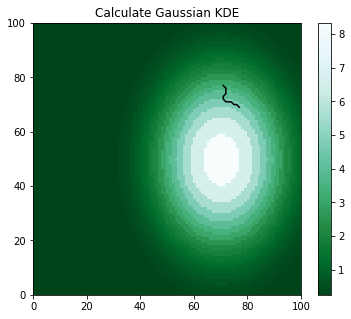

In [462]:
z = np.asarray(y)
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

#x1 = [48, 48]
#y1 = [100 - 31, 100 - 32]

axes.set_title('Calculate Gaussian KDE')
im = axes.pcolormesh(xi,yi, conc, cmap=plt.cm.BuGn_r)
fig.colorbar(im, ax = axes)
plt.plot(x,y,'k')
#plt.plot(x1,y1,'r')
plt.show()

In [463]:
print('Time: ', sumtime)

Time:  0.22408571804407984


In [464]:
# print(y[0:38])

In [465]:

# plt.figure(1,figsize=(17,6))

# ax7 = plt.subplot(2,1,1)
# sh2 = vprobedown[0].plot()
# ax7.set_xlim(0,40)
# ax7.set_ylim(-20000,20000)
# plt.title('pt concentration spikes')

# ax8 = plt.subplot(2,1,2)
# sh2 = uprobedown[0].plot()
# ax8.set_xlim(ax7.get_xlim())
# plt.title('pt delay concentration spikes')

# plt.tight_layout()
# plt.show()

In [466]:
# val4 = 1/val3
# val5 = val4[1:20]
# grad = val5 - val4[0:19]
# val6 = val4[0:19]

# val_new = np.linspace(val6.min(),val6.max(),300)
# a_BSpline = scp.interpolate.make_interp_spline(val6,grad)
# grad_new = a_BSpline(val_new)

# plt.figure(1,figsize=(12,5))

# ax8 = plt.subplot(2,1,1)
# plt.plot(val_new,grad_new)
# plt.scatter(val6,grad)
# #ax8.set_xlim(0,4750)
# plt.xlabel('Spiking Frequency(Hz)', fontsize=18)
# plt.ylabel('Conc.Gradient', fontsize=18)
# #plt.title('',fontsize=18)
# #plt.xticks(t,'')
# #plt.xlabel('')
# plt.yticks([0.5, 1, 1.5], ('0.5', '1.0', '1.5'), fontsize=18)



# #plt.xlabel('time steps', fontsize=18)
# plt.xticks([0,1,2,3,4,5,6],('0','1','2','3','4','5','6'), fontsize=18)
# print(grad)

In [468]:
print(1/np.asarray(val))

[0.25       0.37037037 0.5        0.66666667 0.85470085 1.
 1.0989011  1.2195122  1.38888889 1.61290323 1.88679245 2.17391304
 2.56410256 3.03030303 3.44827586 4.         4.76190476 5.55555556
 6.66666667 8.33333333]
